In [53]:
!pip install imblearn --user

In [54]:
!pip install lime

     |████████████████████████████████| 275 kB 7.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=9c0838a4e7175cc517988b525e452f572a76214d99f3649df446ec56c1adc09a
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [55]:
!pip install shap

     |████████████████████████████████| 564 kB 8.1 MB/s 


# Credit Card Fraud Detection

# Analyze the Data

In [66]:
#Import the relevant modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model
from sklearn.decomposition import PCA
import random
import keras
from keras import backend as K
import pandas as pd
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import collections
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [67]:
#Import the data
df = pd.read_csv('transactions_train.csv')

df.shape

(1048575, 10)

In [68]:
df.head()

step      type    amount     nameOrig  senderOldBalance  senderNewBalance  \
0     1   PAYMENT   9839.64  C1231006815          170136.0         160296.36   
1     1   PAYMENT   1864.28  C1666544295           21249.0          19384.72   
2     1  TRANSFER    181.00  C1305486145             181.0              0.00   
3     1  CASH_OUT    181.00   C840083671             181.0              0.00   
4     1   PAYMENT  11668.14  C2048537720           41554.0          29885.86   

      nameDest  receiverOldBalance  receiverNewBalance  isFraud  
0  M1979787155                 0.0                 0.0        0  
1  M2044282225                 0.0                 0.0        0  
2   C553264065                 0.0                 0.0        1  
3    C38997010             21182.0                 0.0        1  
4  M1230701703                 0.0                 0.0        0

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   step                1048575 non-null  int64  
 1   type                1048575 non-null  object 
 2   amount              1048575 non-null  float64
 3   nameOrig            1048575 non-null  object 
 4   senderOldBalance    1048575 non-null  float64
 5   senderNewBalance    1048575 non-null  float64
 6   nameDest            1048575 non-null  object 
 7   receiverOldBalance  1048575 non-null  float64
 8   receiverNewBalance  1048575 non-null  float64
 9   isFraud             1048575 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 80.0+ MB


In [70]:
df.describe()

step        amount  senderOldBalance  senderNewBalance  \
count  1.048575e+06  1.048575e+06      1.048575e+06      1.048575e+06   
mean   2.696617e+01  1.586670e+05      8.740055e+05      8.938049e+05   
std    1.562325e+01  2.649409e+05      2.971725e+06      3.008246e+06   
min    1.000000e+00  1.000000e-01      0.000000e+00      0.000000e+00   
25%    1.500000e+01  1.214907e+04      0.000000e+00      0.000000e+00   
50%    2.000000e+01  7.634333e+04      1.600200e+04      0.000000e+00   
75%    3.900000e+01  2.137619e+05      1.366420e+05      1.746000e+05   
max    9.500000e+01  1.000000e+07      3.893942e+07      3.894623e+07   

       receiverOldBalance  receiverNewBalance       isFraud  
count        1.048575e+06        1.048575e+06  1.048575e+06  
mean         9.781600e+05        1.114193e+06  1.089097e-03  
std          2.296779e+06        2.416554e+06  3.298351e-02  
min          0.000000e+00        0.000000e+00  0.000000e+00  
25%          0.000000e+00        0.000000e+00  0.000000e+00  
50%          1.263772e+05        2.182604e+05  0.000000e+00  
75%          9.159235e+05        1.149808e+06  0.000000e+00  
max          4.205466e+07        4.216916e+07  1.000000e+00

### Percent of Fraud (1) and Not Fraud (0)

In [71]:
df['isFraud'].value_counts()/df.shape[0]*100 

0    99.89109
1     0.10891
Name: isFraud, dtype: float64

In [72]:
print('Non-Fraud Transaction is',round(df['isFraud'].value_counts()[0]/len(df)*100,2),'% of the dataset')
print('Fraud Transaction is',round(df['isFraud'].value_counts()[1]/len(df)*100,2),'% of the dataset')

Non-Fraud Transaction is 99.89 % of the dataset
Fraud Transaction is 0.11 % of the dataset


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distribution')

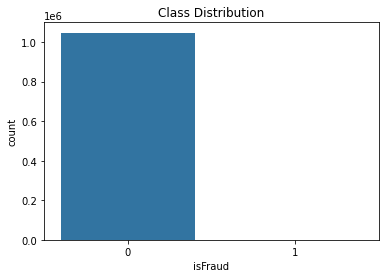

In [73]:
#Plotting the difference betweeen fraud and non-fraud transactions
sns.countplot(df['isFraud'])
plt.title('Class Distribution')

### Creating the Mean Amount field

In [74]:
dict_mean_amount = df.groupby(['nameOrig'])['amount'].agg(['mean']).to_dict()['mean']

In [75]:
df['mean_amount'] = 0.0
for i in range(len(df)):
 df['mean_amount'][i] = dict_mean_amount[df['nameOrig'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
df

step      type     amount     nameOrig  senderOldBalance  \
0           1   PAYMENT    9839.64  C1231006815         170136.00   
1           1   PAYMENT    1864.28  C1666544295          21249.00   
2           1  TRANSFER     181.00  C1305486145            181.00   
3           1  CASH_OUT     181.00   C840083671            181.00   
4           1   PAYMENT   11668.14  C2048537720          41554.00   
...       ...       ...        ...          ...               ...   
1048570    95  CASH_OUT  132557.35  C1179511630         479803.00   
1048571    95   PAYMENT    9917.36  C1956161225          90545.00   
1048572    95   PAYMENT   14140.05  C2037964975          20545.00   
1048573    95   PAYMENT   10020.05  C1633237354          90605.00   
1048574    95   PAYMENT   11450.03  C1264356443          80584.95   

         senderNewBalance     nameDest  receiverOldBalance  \
0               160296.36  M1979787155                0.00   
1                19384.72  M2044282225                0.00   
2                    0.00   C553264065                0.00   
3                    0.00    C38997010            21182.00   
4                29885.86  M1230701703                0.00   
...                   ...          ...                 ...   
1048570         347245.65   C435674507           484329.37   
1048571          80627.64   M668364942                0.00   
1048572           6404.95  M1355182933                0.00   
1048573          80584.95  M1964992463                0.00   
1048574          69134.92   M677577406                0.00   

         receiverNewBalance  isFraud  mean_amount  
0                      0.00        0      9839.64  
1                      0.00        0      1864.28  
2                      0.00        1       181.00  
3                      0.00        1       181.00  
4                      0.00        0     11668.14  
...                     ...      ...          ...  
1048570           616886.72        0    132557.35  
1048571                0.00        0      9917.36  
1048572                0.00        0     14140.05  
1048573                0.00        0     10020.05  
1048574                0.00        0     11450.03  

[1048575 rows x 11 columns]

### Creating the Count of the Sender ID

In [77]:
dict_count_orig = df['nameOrig'].value_counts().to_dict()

In [78]:
df['count_orig'] = 0
for i in range(len(df)):
 df['count_orig'][i] = dict_count_orig[df['nameOrig'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Creating the Count of the Receiver ID

In [79]:
dict_count_dest = df['nameDest'].value_counts().to_dict()

In [80]:
df['count_dest'] = 0
for i in range(len(df)):
 df['count_dest'][i] = dict_count_dest[df['nameDest'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
df

step      type     amount     nameOrig  senderOldBalance  \
0           1   PAYMENT    9839.64  C1231006815         170136.00   
1           1   PAYMENT    1864.28  C1666544295          21249.00   
2           1  TRANSFER     181.00  C1305486145            181.00   
3           1  CASH_OUT     181.00   C840083671            181.00   
4           1   PAYMENT   11668.14  C2048537720          41554.00   
...       ...       ...        ...          ...               ...   
1048570    95  CASH_OUT  132557.35  C1179511630         479803.00   
1048571    95   PAYMENT    9917.36  C1956161225          90545.00   
1048572    95   PAYMENT   14140.05  C2037964975          20545.00   
1048573    95   PAYMENT   10020.05  C1633237354          90605.00   
1048574    95   PAYMENT   11450.03  C1264356443          80584.95   

         senderNewBalance     nameDest  receiverOldBalance  \
0               160296.36  M1979787155                0.00   
1                19384.72  M2044282225                0.00   
2                    0.00   C553264065                0.00   
3                    0.00    C38997010            21182.00   
4                29885.86  M1230701703                0.00   
...                   ...          ...                 ...   
1048570         347245.65   C435674507           484329.37   
1048571          80627.64   M668364942                0.00   
1048572           6404.95  M1355182933                0.00   
1048573          80584.95  M1964992463                0.00   
1048574          69134.92   M677577406                0.00   

         receiverNewBalance  isFraud  mean_amount  count_orig  count_dest  
0                      0.00        0      9839.64           1           1  
1                      0.00        0      1864.28           1           1  
2                      0.00        1       181.00           1          26  
3                      0.00        1       181.00           1          27  
4                      0.00        0     11668.14           1           1  
...                     ...      ...          ...         ...         ...  
1048570           616886.72        0    132557.35           1           3  
1048571                0.00        0      9917.36           1           1  
1048572                0.00        0     14140.05           1           1  
1048573                0.00        0     10020.05           1           1  
1048574                0.00        0     11450.03           1           1  

[1048575 rows x 13 columns]

### Converting the categorical 'Type' field to a numeric ordinal column depending on the count of the individual categories

In [82]:
dict_count_type = df['type'].value_counts().to_dict()

In [83]:
dict_count_type

{'CASH_IN': 227130,
 'CASH_OUT': 373641,
 'DEBIT': 7178,
 'PAYMENT': 353873,
 'TRANSFER': 86753}

In [84]:
df['count_type'] = 0
for i in range(len(df)):
 df['count_type'][i] = dict_count_type[df['type'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
for i in range(len(df)):
  if df['count_type'][i] == 373641:
    df['count_type'][i] = 5
  elif df['count_type'][i] == 353873:
    df['count_type'][i] = 4
  elif df['count_type'][i] == 227130:
    df['count_type'][i] = 3
  elif df['count_type'][i] == 86753:
    df['count_type'][i] = 2
  else:
    df['count_type'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports unti

### Creating a column which gives the total count of the receiver in a particular times frame

In [86]:
df['step_dest_count'] = df.groupby(['step','nameDest'])[['nameDest']].transform('count')

In [87]:
### dropping irrelevant columns
df = df.drop(columns=['step', 'nameOrig', 'nameDest','type'])

In [88]:
df.shape

(1048575, 11)

In this section, we will look at missing value and categorize the columns but since we don't know what columns it is besides the 'Time', 'Amount', and 'Class', we will only look at the missing value.

In [89]:
df.isnull().any()

amount                False
senderOldBalance      False
senderNewBalance      False
receiverOldBalance    False
receiverNewBalance    False
isFraud               False
mean_amount           False
count_orig            False
count_dest            False
count_type            False
step_dest_count       False
dtype: bool

It seems like we don't have any missing value, so we don't have to do anyting here.

## Scaling

In [90]:
### Creating two datasets one will be the scaled and other will be non scaled
dataset = df.copy()
dataset2 = df.copy()
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [91]:
from sklearn.preprocessing import StandardScaler
# copy of datasets
# numerical features
num_cols = ['amount','senderOldBalance','senderNewBalance','receiverOldBalance','receiverNewBalance','mean_amount',	'count_orig',	'count_dest',	'count_type',	'step_dest_count']
# apply standardization on numerical features
for i in num_cols:
  # fit on training data column
  scale = StandardScaler().fit(dataset[[i]])
  # transform the training data column
  dataset[i] = scale.transform(dataset[[i]])

In [92]:
dataset['amount']=NormalizeData(dataset['amount'])
dataset['senderOldBalance']=NormalizeData(dataset['senderOldBalance'])
dataset['senderNewBalance']=NormalizeData(dataset['senderNewBalance'])
dataset['receiverOldBalance']=NormalizeData(dataset['receiverOldBalance'])
dataset['receiverNewBalance']=NormalizeData(dataset['receiverNewBalance'])
dataset['mean_amount']=NormalizeData(dataset['mean_amount'])
dataset['count_orig']=NormalizeData(dataset['count_orig'])
dataset['count_dest']=NormalizeData(dataset['count_dest'])
dataset['count_type']=NormalizeData(dataset['count_type'])
dataset['step_dest_count']=NormalizeData(dataset['step_dest_count'])

In [93]:
dataset

amount  senderOldBalance  senderNewBalance  receiverOldBalance  \
0        0.000984          0.004369          0.004116            0.000000   
1        0.000186          0.000546          0.000498            0.000000   
2        0.000018          0.000005          0.000000            0.000000   
3        0.000018          0.000005          0.000000            0.000504   
4        0.001167          0.001067          0.000767            0.000000   
...           ...               ...               ...                 ...   
1048570  0.013256          0.012322          0.008916            0.011517   
1048571  0.000992          0.002325          0.002070            0.000000   
1048572  0.001414          0.000528          0.000164            0.000000   
1048573  0.001002          0.002327          0.002069            0.000000   
1048574  0.001145          0.002069          0.001775            0.000000   

         receiverNewBalance  isFraud  mean_amount  count_orig  count_dest  \
0                  0.000000        0     0.000984         0.0    0.000000   
1                  0.000000        0     0.000186         0.0    0.000000   
2                  0.000000        1     0.000018         0.0    0.257732   
3                  0.000000        1     0.000018         0.0    0.268041   
4                  0.000000        0     0.001167         0.0    0.000000   
...                     ...      ...          ...         ...         ...   
1048570            0.014629        0     0.013256         0.0    0.020619   
1048571            0.000000        0     0.000992         0.0    0.000000   
1048572            0.000000        0     0.001414         0.0    0.000000   
1048573            0.000000        0     0.001002         0.0    0.000000   
1048574            0.000000        0     0.001145         0.0    0.000000   

         count_type  step_dest_count  
0              0.75              0.0  
1              0.75              0.0  
2              0.25              0.0  
3              1.00              0.0  
4              0.75              0.0  
...             ...              ...  
1048570        1.00              0.0  
1048571        0.75              0.0  
1048572        0.75              0.0  
1048573        0.75              0.0  
1048574        0.75              0.0  

[1048575 rows x 11 columns]

In [94]:
print(dataset.shape)
print(dataset2.shape)

(1048575, 11)
(1048575, 11)


In [95]:
df = dataset.sample(n=50000, random_state=2)
df2 = dataset2.sample(n=50000, random_state=2)

In [96]:
df=df.reset_index()
df2=df2.reset_index()

In [97]:
print(df['isFraud'].value_counts()/df.shape[0]*100 )
print(df2['isFraud'].value_counts()/df.shape[0]*100 )

0    99.866
1     0.134
Name: isFraud, dtype: float64
0    99.866
1     0.134
Name: isFraud, dtype: float64


In [98]:
print(df['isFraud'].value_counts())
print(df2['isFraud'].value_counts())

0    49933
1       67
Name: isFraud, dtype: int64
0    49933
1       67
Name: isFraud, dtype: int64


In [99]:
print(df)
print(df2)

        index    amount  senderOldBalance  senderNewBalance  \
0      597376  0.030130          0.001614          0.009350   
1       71437  0.000511          0.000000          0.000000   
2      738411  0.052328          0.001055          0.000000   
3        8104  0.000249          0.000501          0.000436   
4      127751  0.000454          0.000000          0.000000   
...       ...       ...               ...               ...   
49995   12796  0.011193          0.000000          0.000000   
49996  479999  0.009346          0.000560          0.000000   
49997  403016  0.000956          0.000000          0.000000   
49998  129979  0.001627          0.000532          0.000114   
49999  328021  0.000762          0.000000          0.000000   

       receiverOldBalance  receiverNewBalance  isFraud  mean_amount  \
0                0.231904            0.224129        0     0.030130   
1                0.000000            0.000000        0     0.000511   
2                0.000000     

### SMOTE applied to the dataset

In [100]:
#Determine the X and y
X = df.drop('isFraud', axis=1)
y = df['isFraud']
X2 = df2.drop('isFraud', axis=1)
y2 = df2['isFraud']


from collections import Counter
from imblearn.combine import SMOTETomek

#Implementing the technique
smk = SMOTETomek(random_state=8)

# fit and apply the transform
X_smk, y_smk = smk.fit_resample(X, y)
X2_smk, y2_smk = smk.fit_resample(X2, y2)

# summarize class distribution
print(Counter(y))
print(Counter(y_smk))
print(Counter(y2))
print(Counter(y2_smk))

Counter({0: 49933, 1: 67})
Counter({0: 44180, 1: 44180})
Counter({0: 49933, 1: 67})
Counter({0: 49899, 1: 49899})


In [101]:
#Make a train set dataframe for SMOTE
df_smote = X_smk
df_smote['isFraud']=y_smk
df2_smote = X2_smk
df2_smote['isFraud']=y2_smk

#Reset the index
df_smote['index']=[i for i in range(len(df_smote))]
df_smote = df_smote.set_index('index')
df2_smote['index']=[i for i in range(len(df2_smote))]
df2_smote = df2_smote.set_index('index')

X_smk = X_smk.drop(['index','isFraud'],axis=1)
X2_smk = X2_smk.drop(['index','isFraud'],axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distribution')

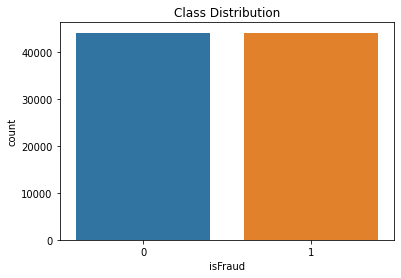

In [102]:
#Plotting the difference betweeen fraud and non-fraud transactions
sns.countplot(df_smote['isFraud'])
plt.title('Class Distribution')

Text(0.5, 1.0, 'After SMOTE')

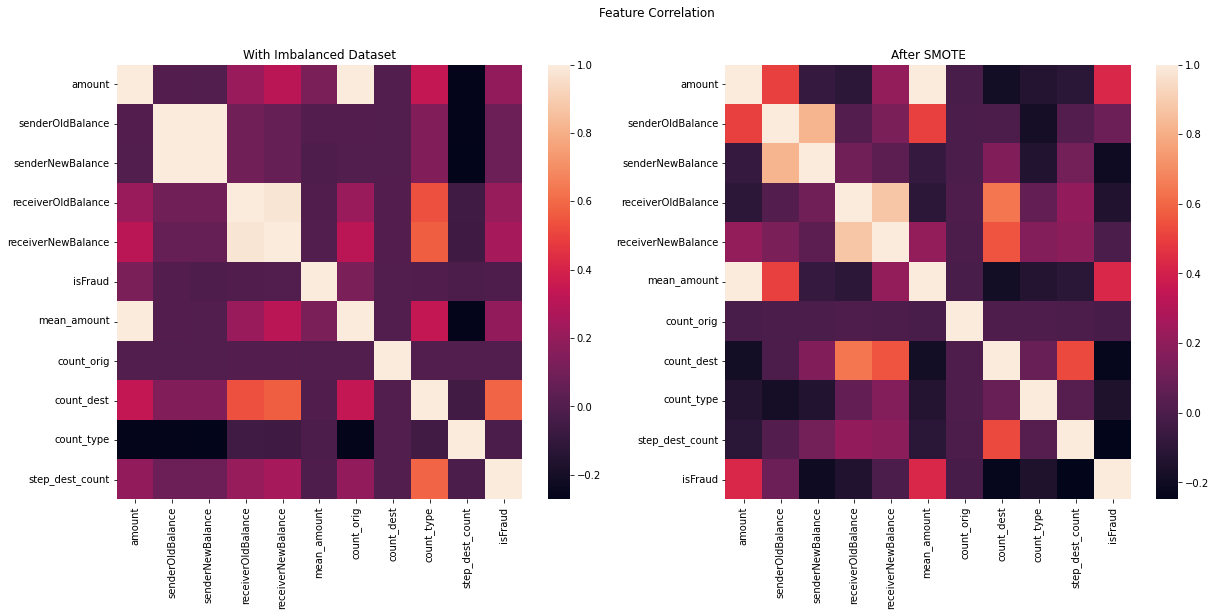

In [103]:
#Plot a heatmap
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,8))
fig.suptitle('Feature Correlation')

#Imbalanced Dataset
sns.heatmap(dataset.corr(),ax=axes[0])
axes[0].set_title('With Imbalanced Dataset')

#Data after SMOTE
sns.heatmap(df_smote.corr(),ax=axes[1])
axes[1].set_title('After SMOTE')

### Dataset Random Under-Sampling

In [104]:
# import the library
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_us, y_us = undersample.fit_resample(X, y)

# summarize class distribution
print(Counter(y))
print(Counter(y_us))

Counter({0: 49933, 1: 67})
Counter({0: 67, 1: 67})


In [105]:
#Make a train set dataframe for random under sampling
df_us = X_us
df_us['isFraud']=y_us

#Reset the index
df_us['index']=[i for i in range(len(df_us))]
df_us = df_us.set_index('index')

X_us = X_us.drop(['index','isFraud'],axis=1)

## Analyze each Dataset

Here we will compare these dataset to find which technique fits the best for this imbalanced dataset:
1. Random Under Sampling
2. SMOTE
3. Original Dataset

In [106]:
datas = {'Random-Under-Sampling': df_us, 'SMOTE' : df_smote, 'Ori Dataset':dataset}

precision_recall_score={}
crossval_score={}
class_report={}
accuracyscore={} 
f1score={}
rocauc_score={}

### Precision-Recall Curve 

In [107]:
# precision-recall curve and f1
f1={}
aucscore={}
recall={}
precision={}

for i in range(len(datas)):
    #Split dataset
    X = (list(datas.values())[i]).drop('isFraud', axis=1)
    y = (list(datas.values())[i])['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

    # Turn the values into an array for feeding the classification algorithms.
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    
    #fit into a model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)

    # predict probabilities
    lr_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # predict class values
    yhat = model.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

    # summarize scores
    recall[list(datas.keys())[i]]=lr_recall
    precision[list(datas.keys())[i]]=lr_precision
    
    f1[list(datas.keys())[i]]=f1_score(y_test, yhat)
    aucscore[list(datas.keys())[i]]=auc(lr_recall, lr_precision)

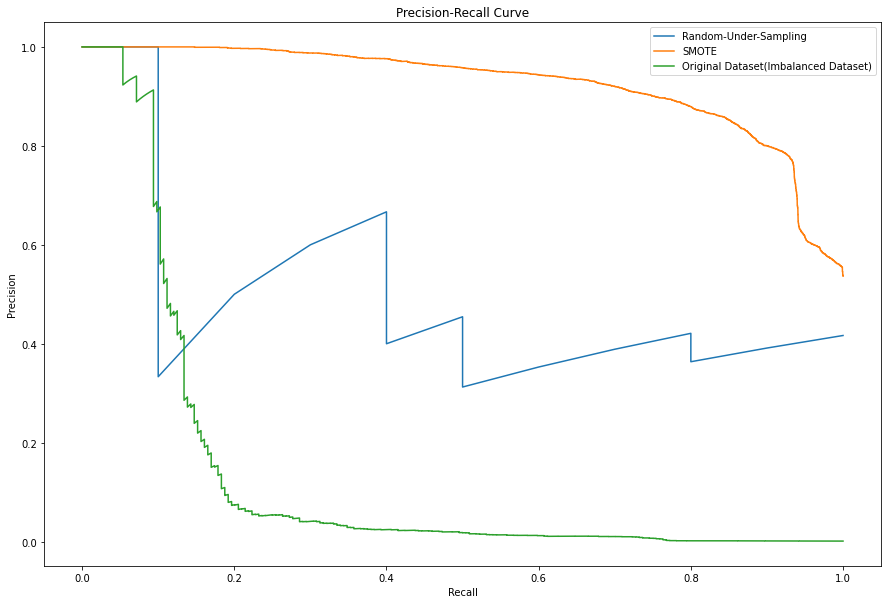

In [108]:
# plot the precision-recall curves 
plt.plot(list(recall.values())[0], list(precision.values())[0],  label=list(recall.keys())[0])
plt.plot(list(recall.values())[1], list(precision.values())[1],  label=list(recall.keys())[1])
plt.plot(list(recall.values())[2], list(precision.values())[2],  label='Original Dataset(Imbalanced Dataset)')

# axis labels
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the legend
plt.legend()

# show the plot
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

### ROC-AUC Curve

In [109]:
# roc curve and auc


auc2={}
fpr={}
tpr={}

for i in range(len(datas)):
    #Split dataset
    X = (list(datas.values())[i]).drop('isFraud', axis=1)
    y = (list(datas.values())[i])['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

    # Turn the values into an array for feeding the classification algorithms.
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    
    #fit into a model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)

    # predict probabilities
    lr_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # calculate scores
    lr_auc = roc_auc_score(y_test, lr_probs)
    
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    
    auc2[list(datas.keys())[i]]=lr_auc
    fpr[list(datas.keys())[i]]=lr_fpr
    tpr[list(datas.keys())[i]]=lr_tpr

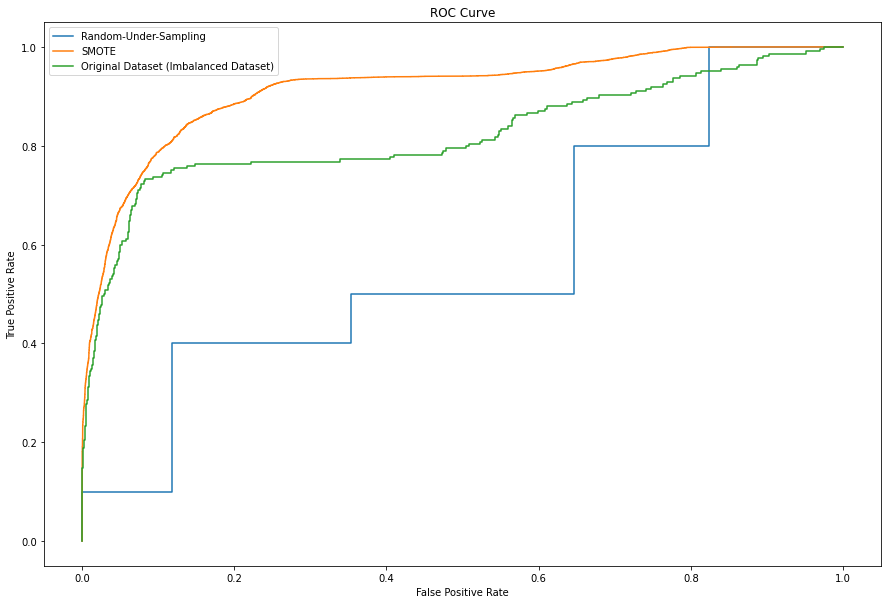

In [110]:
# plot the roc curve for the model
plt.plot(list(fpr.values())[0], list(tpr.values())[0],  label=list(tpr.keys())[0])
plt.plot(list(fpr.values())[1], list(tpr.values())[1],  label=list(tpr.keys())[1])
plt.plot(list(fpr.values())[2], list(tpr.values())[2],  label='Original Dataset (Imbalanced Dataset)')

# axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)

# show the plot
plt.show()

Since from both Precision-Recall and ROC-AUC curve, the dataset wiht SMOTE Technique fits the best we will use that dataset.

## Implement Model

In this project we will use these model and compare it to find which one fits the best for this dataset :
    1. Logistic Regression
    2. K-Nearest Neighbor
    3. Support Vector Machine
    4. Decision Tree
    5. Deep Neural Network

In [141]:
X = df_smote.drop('isFraud', axis=1)
y = df_smote['isFraud']
X2= df2_smote.drop('isFraud', axis=1)
y2= df2_smote['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state = 42)

In [142]:
#import library needed
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": LinearSVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [143]:
## Deep Learning Model
initializer = tf.keras.initializers.HeNormal()
baseline = Sequential()
baseline.add(Dense(60, input_dim=10, activation='relu',kernel_initializer=initializer))
baseline.add(Dense(30, activation='relu',kernel_initializer=initializer))
baseline.add(Dense(1, activation='sigmoid'))

In [144]:
baseline.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 60)                660       
                                                                 
 dense_7 (Dense)             (None, 30)                1830      
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________


In [145]:
baseline.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [146]:
baseline.fit(X_train,y_train,epochs=40)

Train on 70688 samples
Epoch 1/40
70688/70688 [==============================] - 3s 43us/sample - loss: 0.2965 - acc: 0.8661
Epoch 2/40
70688/70688 [==============================] - 3s 42us/sample - loss: 0.1314 - acc: 0.9480
Epoch 3/40
70688/70688 [==============================] - 3s 42us/sample - loss: 0.0822 - acc: 0.9711
Epoch 4/40
70688/70688 [==============================] - 3s 41us/sample - loss: 0.0623 - acc: 0.9782
Epoch 5/40
70688/70688 [==============================] - 3s 42us/sample - loss: 0.0541 - acc: 0.9816
Epoch 6/40
70688/70688 [==============================] - 3s 41us/sample - loss: 0.0474 - acc: 0.9841
Epoch 7/40
70688/70688 [==============================] - 3s 41us/sample - loss: 0.0446 - acc: 0.9851
Epoch 8/40
70688/70688 [==============================] - 3s 42us/sample - loss: 0.0422 - acc: 0.9857
Epoch 9/40
70688/70688 [==============================] - 3s 42us/sample - loss: 0.0408 - acc: 0.9861
Epoch 10/40
70688/70688 [==============================] - 

In [147]:
baseline.evaluate(X_test,y_test)[1]

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


0.9950204

In [148]:
f1_ml={}
aucscore_ml={}
recall_ml={}
precision_ml={}
for key, classifier in classifiers.items():
    #fit dataset into a machine learning
    if key=="Support Vector Classifier":
        svm = LinearSVC()
        clf = CalibratedClassifierCV(svm) 
        model = clf.fit(X_train,y_train)
    else:
        model = classifier.fit(X_train, y_train)

    # predict probabilities
    lr_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # predict class values
    yhat = model.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

    # summarize scores
    recall_ml[key]=lr_recall
    precision_ml[key]=lr_precision
    
    f1_ml[key]=f1_score(y_test, yhat)
    aucscore_ml[key]=auc(lr_recall, lr_precision)
 # DL Model Score   
lr_probs = baseline.predict(X_test)
yhat =tf.argmax(lr_probs, axis=-1).eval(session=tf.compat.v1.Session())
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
 # summarize scores
recall_ml["Deep Learning"]=lr_recall
precision_ml["Deep Learning"]=lr_precision
f1_ml["Deep Learning"]=f1_score(y_test, yhat)
aucscore_ml["Deep Learning"]=auc(lr_recall, lr_precision)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [149]:
aucscore_ml

{'DecisionTreeClassifier': 0.997959066968421,
 'Deep Learning': 0.999766251879082,
 'KNearest': 0.9984482175496087,
 'LogisiticRegression': 0.9237920051781238,
 'Support Vector Classifier': 0.9689639734716902}

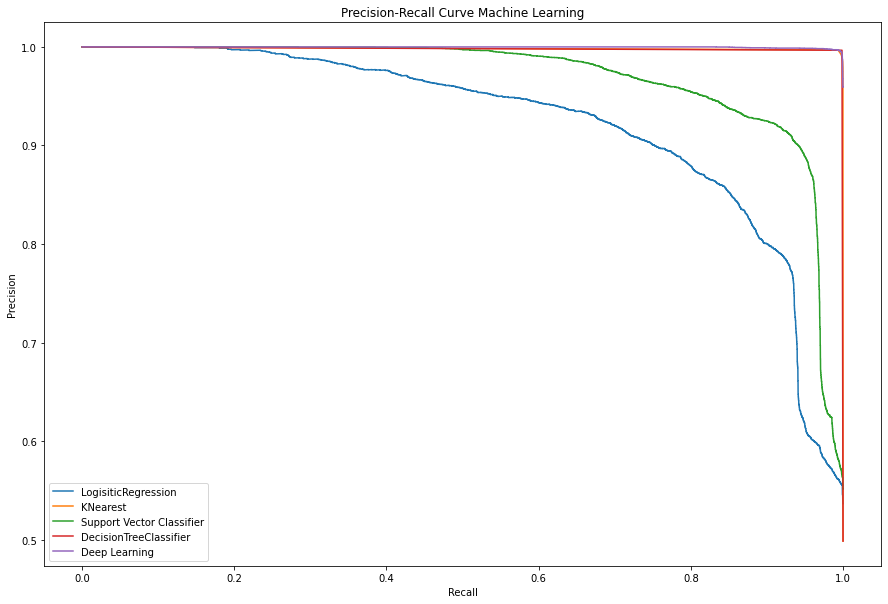

In [150]:
# plot the precision-recall curves 
plt.plot(list(recall_ml.values())[0], list(precision_ml.values())[0],  label=list(recall_ml.keys())[0])
plt.plot(list(recall_ml.values())[1], list(precision_ml.values())[1],  label=list(recall_ml.keys())[1])
plt.plot(list(recall_ml.values())[2], list(precision_ml.values())[2],  label=list(recall_ml.keys())[2])
plt.plot(list(recall_ml.values())[3], list(precision_ml.values())[3],  label=list(recall_ml.keys())[3])
plt.plot(list(recall_ml.values())[4], list(precision_ml.values())[4],  label=list(recall_ml.keys())[4])
# axis labels
plt.title('Precision-Recall Curve Machine Learning')
plt.xlabel('Recall')
plt.ylabel('Precision')

# show the legend
plt.legend()

# show the plot
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

In [151]:
# roc curve and auc
auc2_ml={}
fpr_ml={}
tpr_ml={}

for key, classifier in classifiers.items():
    #fit dataset into a machine learning
    if key=="Support Vector Classifier":
        svm = LinearSVC()
        clf = CalibratedClassifierCV(svm) 
        model = clf.fit(X_train,y_train)
    else:
        model = classifier.fit(X_train, y_train)

    # predict probabilities
    lr_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # calculate scores
    lr_auc = roc_auc_score(y_test, lr_probs)
    
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    
    auc2_ml[key]=lr_auc
    fpr_ml[key]=lr_fpr
    tpr_ml[key]=lr_tpr
lr_probs = baseline.predict(X_test)
lr_auc = roc_auc_score(y_test, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
auc2_ml["Deep Learning"]=lr_auc
fpr_ml["Deep Learning"]=lr_fpr
tpr_ml["Deep Learning"]=lr_tpr

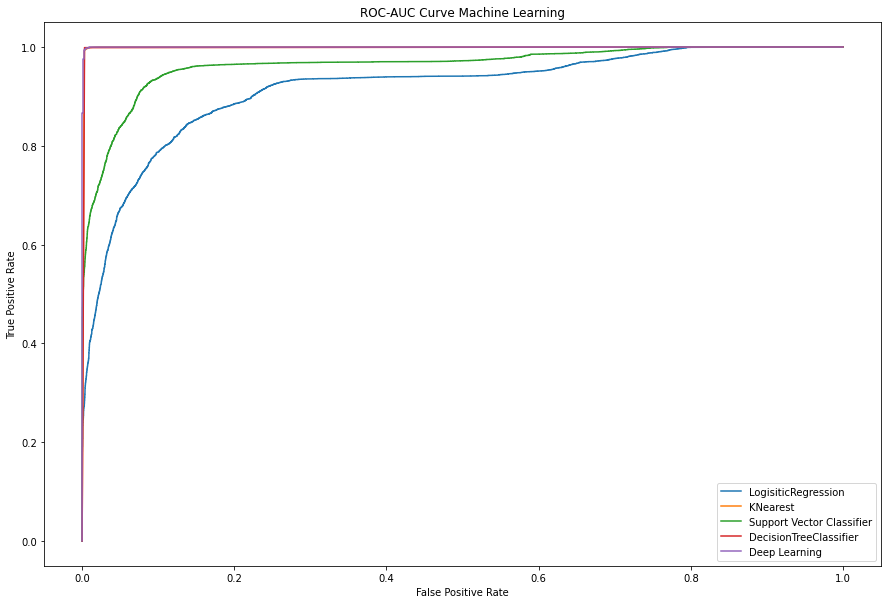

In [152]:
# plot the roc curve for the model
plt.plot(list(fpr_ml.values())[0], list(tpr_ml.values())[0],  label=list(tpr_ml.keys())[0])
plt.plot(list(fpr_ml.values())[1], list(tpr_ml.values())[1],  label=list(tpr_ml.keys())[1])
plt.plot(list(fpr_ml.values())[2], list(tpr_ml.values())[2],  label=list(tpr_ml.keys())[2])
plt.plot(list(fpr_ml.values())[3], list(tpr_ml.values())[3],  label=list(tpr_ml.keys())[3])
plt.plot(list(fpr_ml.values())[4], list(tpr_ml.values())[4],  label=list(tpr_ml.keys())[4])

# axis labels
plt.title('ROC-AUC Curve Machine Learning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
fig = plt.gcf()
fig.set_size_inches(15, 10)

# show the plot
plt.show()

In [153]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg = LogisticRegression(solver='lbfgs')
knears_neighbors = KNeighborsClassifier()
svc = LinearSVC()
tree_clf = DecisionTreeClassifier()
# Create a DataFrame with all the scores and the classifiers names.
log_reg_pred = cross_val_predict(log_reg, X_test, y_test, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_test, y_test, cv=5)

svc_pred = cross_val_predict(svc, X_test, y_test, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_test, y_test, cv=5)

dnn_pred = baseline.predict(X_test)



from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_test, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_test, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_test, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_test, tree_pred))
print('Deep Learning: ', roc_auc_score(y_test, dnn_pred ))



Logistic Regression:  0.8987882637287697
KNears Neighbors:  0.9777945949778754
Support Vector Classifier:  0.9332719745828348
Decision Tree Classifier:  0.992081247565536
Deep Learning:  0.999777762598479


In [154]:
acc = {}
for key, classifier in classifiers.items():
    #fit dataset into a machine learning
    if key=="Support Vector Classifier":
        svm = LinearSVC()
        clf = CalibratedClassifierCV(svm) 
        model = clf.fit(X_train,y_train)
    else:
        model = classifier.fit(X_train, y_train)

    # predict probabilities
    y_pred = model.predict(X_test)

    acc[classifier] = accuracy_score(y_test,y_pred)

acc['Deep Learning'] = baseline.evaluate(X_test,y_test)[1]



In [155]:
print(acc)

{LogisticRegression(): 0.8253168854685378, KNeighborsClassifier(): 0.9942847442281575, LinearSVC(): 0.8597781801720236, DecisionTreeClassifier(): 0.9976233589859665, 'Deep Learning': 0.9950204}


## Lime Explanations

In [168]:
y2_test.iloc[5016]

0

In [156]:
from IPython.display import Javascript
display(Javascript("google.colab.output.resizeIframeToContent()"))


import lime 
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X2_train),
    feature_names=X2_train.columns,
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

#test_1 = X_test.iloc[1]
test_2 = X2_test.iloc[5016]

lime_exp = lime_explainer.explain_instance(
    data_row=test_2,
    predict_fn=model.predict_proba
)
lime_exp.show_in_notebook()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


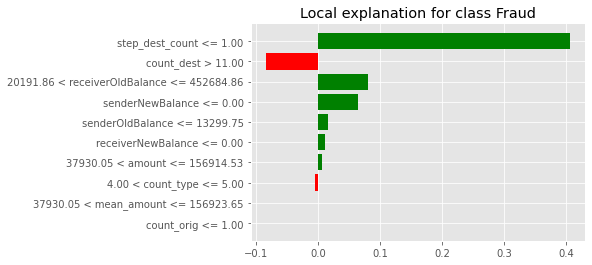

In [157]:
 with plt.style.context("ggplot"):
    lime_exp.as_pyplot_figure()

In [158]:
y2_test.iloc[500]

1

In [159]:
from IPython.display import Javascript
display(Javascript("google.colab.output.resizeIframeToContent()"))


import lime 
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X2_train),
    feature_names=X2_train.columns,
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

#test_1 = X_test.iloc[1]
test_2 = X2_test.iloc[500]

lime_exp = lime_explainer.explain_instance(
    data_row=test_2,
    predict_fn=model.predict_proba
)
lime_exp.show_in_notebook()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


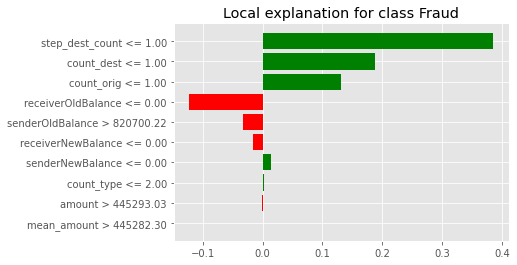

In [160]:
with plt.style.context("ggplot"):
    lime_exp.as_pyplot_figure()

In [162]:
y2_test.iloc[11443]

1

In [163]:
from IPython.display import Javascript
display(Javascript("google.colab.output.resizeIframeToContent()"))


import lime 
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X2_train),
    feature_names=X2_train.columns,
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

#test_1 = X_test.iloc[1]
test_2 = X2_test.iloc[11443]

lime_exp = lime_explainer.explain_instance(
    data_row=test_2,
    predict_fn=model.predict_proba
)
lime_exp.show_in_notebook()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


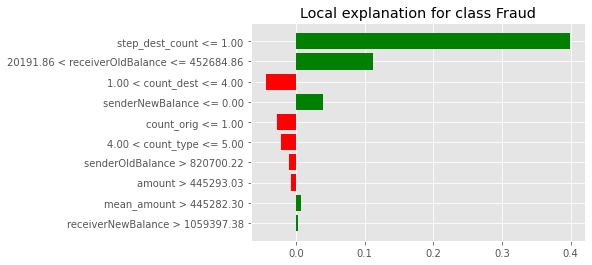

In [164]:
with plt.style.context("ggplot"):
    lime_exp.as_pyplot_figure()

In [165]:
y2_test.iloc[114]

1

In [166]:
from IPython.display import Javascript
display(Javascript("google.colab.output.resizeIframeToContent()"))


import lime 
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X2_train),
    feature_names=X2_train.columns,
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

#test_1 = X_test.iloc[1]
test_2 = X2_test.iloc[114]

lime_exp = lime_explainer.explain_instance(
    data_row=test_2,
    predict_fn=model.predict_proba
)
lime_exp.show_in_notebook()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


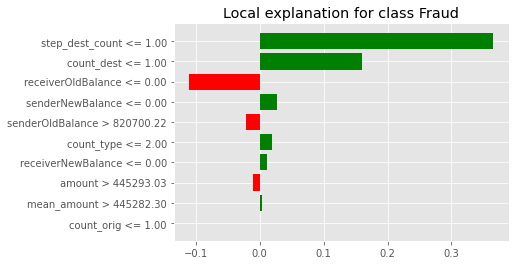

In [167]:
with plt.style.context("ggplot"):
    lime_exp.as_pyplot_figure()

## Shap

In [192]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model,X2_train)

In [193]:
shap_values = explainer.shap_values(X2_test)

In [176]:
X2_test.iloc[1, :]

amount                3063.38
senderOldBalance         0.00
senderNewBalance         0.00
receiverOldBalance       0.00
receiverNewBalance       0.00
mean_amount           3063.38
count_orig               1.00
count_dest               1.00
count_type               4.00
step_dest_count          1.00
Name: 41388, dtype: float64

In [177]:
X2_test.iloc[115,:]

amount                8.763792e+06
senderOldBalance      8.763792e+06
senderNewBalance      0.000000e+00
receiverOldBalance    4.064745e+05
receiverNewBalance    9.170267e+06
mean_amount           8.763792e+06
count_orig            1.000000e+00
count_dest            4.000000e+00
count_type            5.000000e+00
step_dest_count       1.000000e+00
Name: 51652, dtype: float64

In [178]:
y2_test.iloc[115]

1

In [194]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][115,:], X2_test.iloc[115,:])

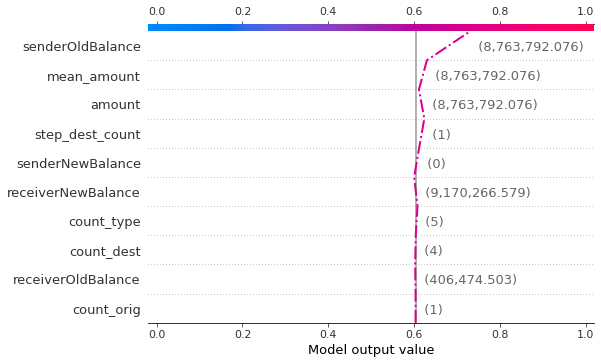

In [195]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][115,:], X2_test.iloc[115,:],
                   link='logit', highlight=0)

In [198]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][14,:], X2_test.iloc[14,:])

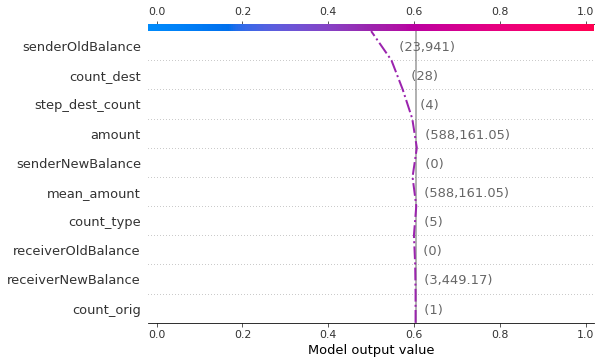

In [199]:
shap.decision_plot(explainer.expected_value[1], shap_values[1][14,:], X2_test.iloc[14,:],
                   link='logit', highlight=0)

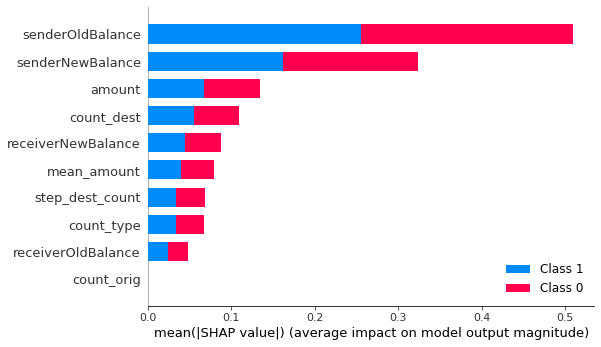

In [196]:
shap.summary_plot(shap_values, X2_test, plot_type='bar')

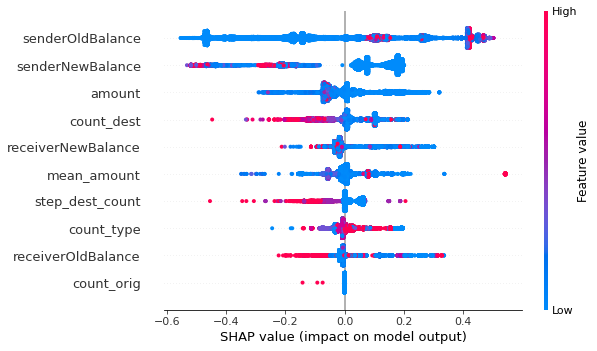

In [197]:
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X2_test
                  #,use_log_scale=True
                 )